In [1]:
from pathlib import Path
import pandas as pd

# This notebook lives in /notebooks → go up one level to repo root
ROOT = Path.cwd().resolve().parent
PROCESSED = ROOT / "data" / "01_caldashboard" / "processed"
ASSETS = ROOT / "projects" / "01_california-dashboard-replica" / "assets"

#PROCESSED = Path("/Users/ms/Projects/acoe-edu-data-portfolio/data/01_caldashboard/processed")
#ASSETS = Path("/Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets")

ASSETS.mkdir(parents=True, exist_ok=True)

# Files produced by 02_kpi_calculations.ipynb
WIDE_FP = PROCESSED / "kpi_chronic_wide_all_levels.csv"
LONG_FP = PROCESSED / "kpi_chronic_long_all_levels.csv"

# Read
wide = pd.read_csv(WIDE_FP)
long = pd.read_csv(LONG_FP)

# Basic typing
for col in ("year","cohort"):
    if col in wide: wide[col] = pd.to_numeric(wide[col], errors="coerce")
    if col in long: long[col] = pd.to_numeric(long[col], errors="coerce")

YEARS = sorted([int(y) for y in wide["year"].dropna().unique()]) if "year" in wide else []
DEFAULT_YEAR = YEARS[-1] if YEARS else None
print("Processed dir:", PROCESSED)
print("Assets dir:", ASSETS)
print("Years:", YEARS, "| Default:", DEFAULT_YEAR)

Processed dir: /Users/ms/Projects/acoe-edu-data-portfolio/data/01_caldashboard/processed
Assets dir: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets
Years: [2024] | Default: 2024


In [2]:
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def slugify(s: str) -> str:
    s = "" if s is None else str(s)
    return re.sub(r"[^a-z0-9]+", "-", s.lower()).strip("-")[:80] or "na"

def filter_all_students(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["subgroup"].astype(str).str.lower().isin(["all","all students"])]

def pick_default(series):
    s = series.dropna()
    return s.sort_values().iloc[0] if not s.empty else None

In [3]:
YEAR = DEFAULT_YEAR  # e.g., 2023

# Pick a district
candidates = wide.loc[wide["geo_level"].str.lower().eq("district"), "district_name"].dropna().unique()
DISTRICT = next((d for d in candidates if "san francisco" in str(d).lower()), None) or pick_default(pd.Series(candidates))

DISTRICT = "San Francisco County Office of Education"  # paste the exact match you saw printed
print("YEAR:", YEAR)
print("DISTRICT:", DISTRICT)


YEAR: 2024
DISTRICT: San Francisco County Office of Education


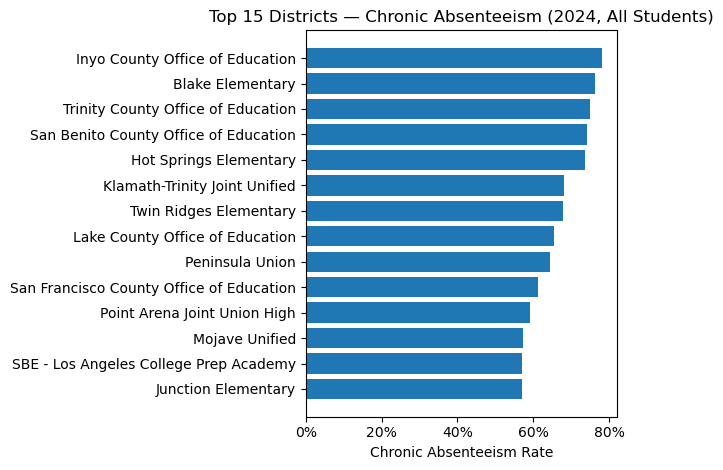

Saved: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/top15_districts_chronic_2024.png


In [4]:
df = wide.copy()
df = df[(df["geo_level"]=="district") & (df["year"]==YEAR)]
df = filter_all_students(df).dropna(subset=["chronic_absent_rate"])

if df.empty:
    print("No district-level All Students data for", YEAR)
else:
    top = df.sort_values("chronic_absent_rate", ascending=False).head(15)
    top.to_csv(ASSETS / f"top15_districts_chronic_{YEAR}.csv", index=False)

    plt.figure()
    plt.barh(top["district_name"], top["chronic_absent_rate"])
    plt.gca().invert_yaxis()
    plt.xlabel("Chronic Absenteeism Rate")
    plt.title(f"Top 15 Districts — Chronic Absenteeism ({YEAR}, All Students)")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()
    out_png = ASSETS / f"top15_districts_chronic_{YEAR}.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print("Saved:", out_png)


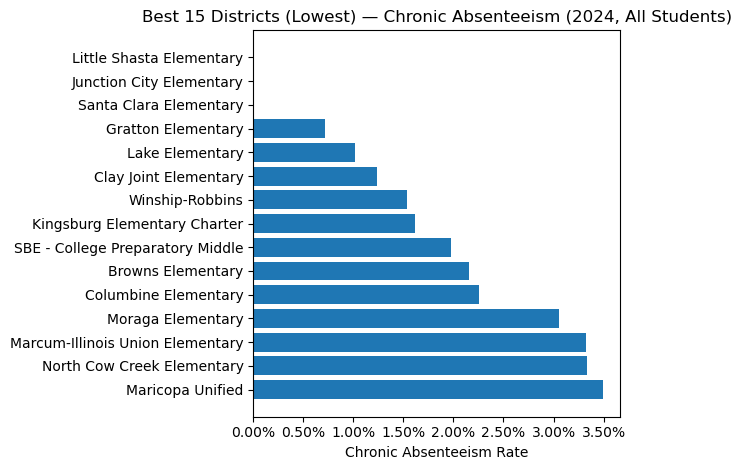

Saved: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/best15_districts_chronic_2024.png


In [5]:
df = wide.copy()
df = df[(df["geo_level"]=="district") & (df["year"]==YEAR)]
df = filter_all_students(df).dropna(subset=["chronic_absent_rate"])

if df.empty:
    print("No district-level All Students data for", YEAR)
else:
    best = df.sort_values("chronic_absent_rate", ascending=True).head(15)
    best.to_csv(ASSETS / f"best15_districts_chronic_{YEAR}.csv", index=False)

    plt.figure()
    plt.barh(best["district_name"], best["chronic_absent_rate"])
    plt.gca().invert_yaxis()
    plt.xlabel("Chronic Absenteeism Rate")
    plt.title(f"Best 15 Districts (Lowest) — Chronic Absenteeism ({YEAR}, All Students)")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()
    out_png = ASSETS / f"best15_districts_chronic_{YEAR}.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print("Saved:", out_png)


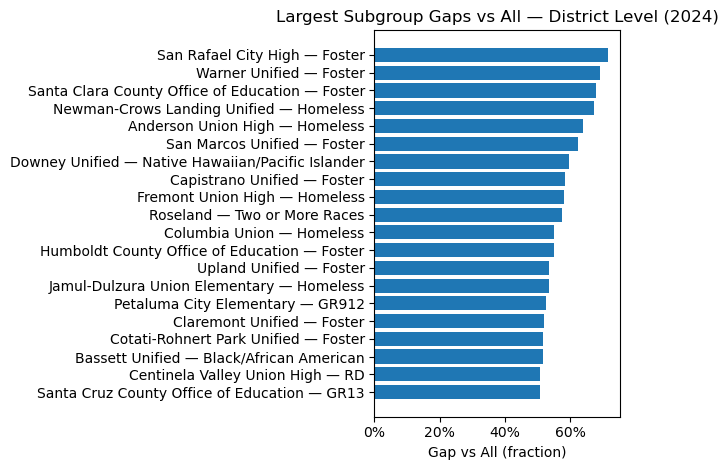

Saved: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/largest_equity_gaps_2024.png


In [6]:
df = wide.copy()
df = df[(df["geo_level"]=="district") & (df["year"]==YEAR)].copy()

# If gap_vs_all not present, compute quickly
if "gap_vs_all" not in df.columns:
    all_rows = filter_all_students(df)[["district_name","year","chronic_absent_rate"]] \
                .rename(columns={"chronic_absent_rate":"rate_all"})
    df = df.merge(all_rows, on=["district_name","year"], how="left")
    df["gap_vs_all"] = df["chronic_absent_rate"] - df["rate_all"]

sub = df[~df["subgroup"].astype(str).str.lower().isin(["all","all students"])].dropna(subset=["gap_vs_all"])
if sub.empty:
    print("No subgroup rows for equity gap chart.")
else:
    top_gap = sub.sort_values("gap_vs_all", ascending=False).head(20)
    top_gap.to_csv(ASSETS / f"largest_equity_gaps_{YEAR}.csv", index=False)

    labels = top_gap["district_name"] + " — " + top_gap["subgroup"].astype(str)
    plt.figure()
    plt.barh(labels, top_gap["gap_vs_all"])
    plt.gca().invert_yaxis()
    plt.xlabel("Gap vs All (fraction)")
    plt.title(f"Largest Subgroup Gaps vs All — District Level ({YEAR})")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()
    out_png = ASSETS / f"largest_equity_gaps_{YEAR}.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print("Saved:", out_png)



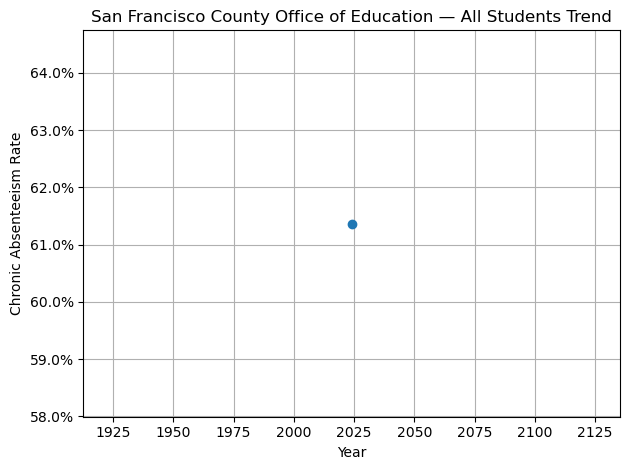

Saved: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/trend_chronic_san-francisco-county-office-of-education.png


In [7]:
df = wide.copy()
mask = (
    df["geo_level"].str.lower().eq("district")
    & df["district_name"].astype(str).eq(DISTRICT)
    & df["subgroup"].astype(str).str.lower().isin(["all","all students"])
)
trend = df.loc[mask, ["year","chronic_absent_rate"]].dropna().sort_values("year")

if trend.empty:
    print("No trend data for:", DISTRICT)
else:
    plt.figure()
    plt.plot(trend["year"], trend["chronic_absent_rate"], marker="o")
    plt.xlabel("Year")
    plt.ylabel("Chronic Absenteeism Rate")
    plt.title(f"{DISTRICT} — All Students Trend")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.grid(True); plt.tight_layout()
    out_png = ASSETS / f"trend_chronic_{slugify(DISTRICT)}.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print("Saved:", out_png)


District: ABC Unified


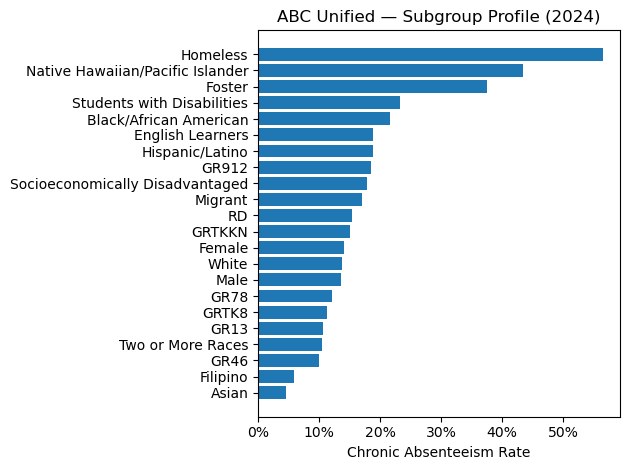

Saved figure: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/subgroup_profile__abc-unified_2024.png


In [8]:
candidates = wide.loc[wide["geo_level"]=="district","district_name"].dropna().unique()
DISTRICT = pick_default(pd.Series(candidates))  # set to a preferred district
print("District:", DISTRICT)

df = wide.copy()
df = df[(df["geo_level"]=="district") & (df["district_name"]==DISTRICT)].copy()
df = df[~df["subgroup"].astype(str).str.lower().isin(["all","all students"])]  # exclude All
df = df.dropna(subset=["chronic_absent_rate"])
df = df.sort_values("chronic_absent_rate", ascending=False)

if df.empty:
    print("No subgroup for this district.", DISTRICT, YEAR)
else:
    plt.figure()
    plt.barh(df["subgroup"], df["chronic_absent_rate"])
    plt.gca().invert_yaxis()
    plt.xlabel("Chronic Absenteeism Rate")
    plt.title(f"{DISTRICT} — Subgroup Profile ({YEAR})")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()
    out_png = ASSETS / f"subgroup_profile__{slugify(DISTRICT)}_{YEAR}.png"
    plt.savefig(out_png, dpi=150)
    plt.show()
    print("Saved figure:", out_png.as_posix())


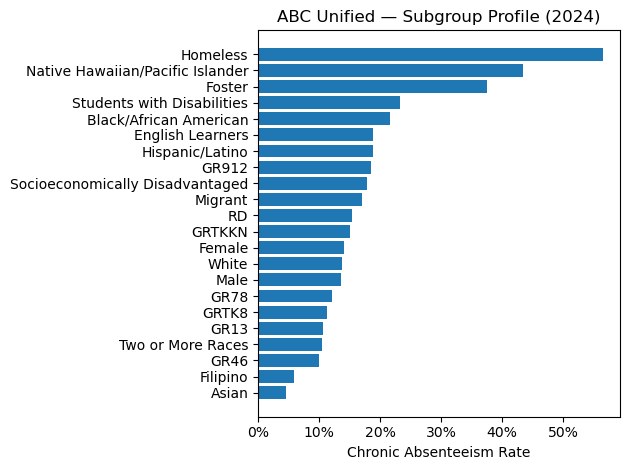

Saved: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/subgroup_profile_abc-unified_2024.png


In [9]:
df = wide.copy()
mask = (
    df["geo_level"].str.lower().eq("district")
    & df["district_name"].astype(str).eq(DISTRICT)
    & df["year"].eq(YEAR)
)
subg = df.loc[mask].copy()
subg = subg[~subg["subgroup"].astype(str).str.lower().isin(["all","all students"])]
subg = subg.dropna(subset=["chronic_absent_rate"]).sort_values("chronic_absent_rate", ascending=False)

if subg.empty:
    print("No subgroup rows for", DISTRICT, YEAR)
else:
    plt.figure()
    plt.barh(subg["subgroup"], subg["chronic_absent_rate"])
    plt.gca().invert_yaxis()
    plt.xlabel("Chronic Absenteeism Rate")
    plt.title(f"{DISTRICT} — Subgroup Profile ({YEAR})")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()
    out_png = ASSETS / f"subgroup_profile_{slugify(DISTRICT)}_{YEAR}.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print("Saved:", out_png)


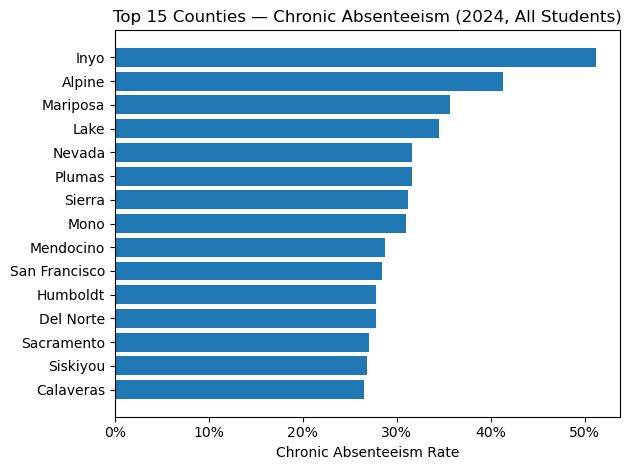

Saved: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/top15_counties_chronic_2024.png


In [10]:
df = wide.copy()
df = df[(df["geo_level"]=="county") & (df["year"]==YEAR)]
df = filter_all_students(df).dropna(subset=["chronic_absent_rate"])

if df.empty:
    print("No county-level All Students data for", YEAR)
else:
    top = df.sort_values("chronic_absent_rate", ascending=False).head(15)
    top.to_csv(ASSETS / f"top15_counties_chronic_{YEAR}.csv", index=False)

    plt.figure()
    plt.barh(top["county_name"], top["chronic_absent_rate"])
    plt.gca().invert_yaxis()
    plt.xlabel("Chronic Absenteeism Rate")
    plt.title(f"Top 15 Counties — Chronic Absenteeism ({YEAR}, All Students)")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()
    out_png = ASSETS / f"top15_counties_chronic_{YEAR}.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print("Saved:", out_png)


In [11]:
# District-level, All Students only
#dist_all = wide[(wide["geo_level"]=="district")].pipe(filter_all_students)
dist_all = wide[(wide["geo_level"]=="district")].copy()
dist_all = filter_all_students(dist_all)
dist_all.to_csv(PROCESSED / "tableau_district_all.csv", index=False)

# County-level, All Students only
#cnty_all = wide[(wide["geo_level"]=="county")].pipe(filter_all_students)
cnty_all = wide[(wide["geo_level"]=="county")].copy()
cnty_all = filter_all_students(cnty_all)
cnty_all.to_csv(PROCESSED / "tableau_county_all.csv", index=False)

# Long-format, all levels (for general charts)
long.to_csv(PROCESSED / "tableau_long_all.csv", index=False)

print("Saved tableau-ready extracts:",
      (PROCESSED / "tableau_district_all.csv").as_posix(),
      (PROCESSED / "tableau_county_all.csv").as_posix(),
      (PROCESSED / "tableau_long_all.csv").as_posix())


Saved tableau-ready extracts: /Users/ms/Projects/acoe-edu-data-portfolio/data/01_caldashboard/processed/tableau_district_all.csv /Users/ms/Projects/acoe-edu-data-portfolio/data/01_caldashboard/processed/tableau_county_all.csv /Users/ms/Projects/acoe-edu-data-portfolio/data/01_caldashboard/processed/tableau_long_all.csv


In [12]:
imgs = sorted(ASSETS.glob("*.png"))
tbls = sorted(ASSETS.glob("*.csv"))
print("Figures:")
for p in imgs: print(" -", p.name)
print("\nTables:")
for p in tbls: print(" -", p.name)


Figures:
 - best15_districts_chronic_2024.png
 - largest_equity_gaps_2024.png
 - reporting_category_profile__abc-unified.png
 - reporting_category_profile__burbank-unified.png
 - subgroup_profile__abc-unified_2024.png
 - subgroup_profile__burbank-unified.png
 - subgroup_profile__san-francisco-county-office-of-education.png
 - subgroup_profile__santa-clara-county-office-of-education.png
 - subgroup_profile__santa-clara-elementary.png
 - subgroup_profile__santa-clara-unified.png
 - subgroup_profile__warner-unified.png
 - subgroup_profile_abc-unified_2024.png
 - subgroup_profile_burbank-unified_2024.png
 - top15_counties_chronic_2024.png
 - top15_districts_chronic_2024.png
 - trend_chronic_burbank-unified.png
 - trend_chronic_san-francisco-county-office-of-education.png

Tables:
 - best15_districts_chronic_2024.csv
 - largest_equity_gaps_2024.csv
 - top15_counties_chronic_2024.csv
 - top15_districts_chronic_2024.csv


In [13]:
cands = (wide.loc[wide["geo_level"].str.lower().eq("district"), "district_name"]
             .dropna().unique())
[name for name in cands if "santa clara" in str(name).lower()]


['Santa Clara County Office of Education',
 'Santa Clara Elementary',
 'Santa Clara Unified']

District: Santa Clara Unified


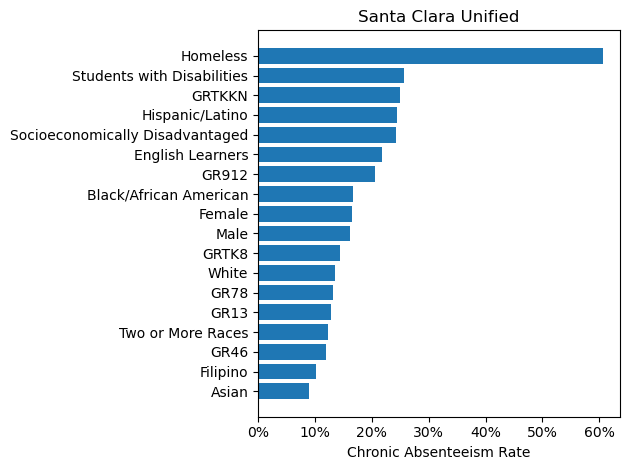

Saved figure: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/subgroup_profile__santa-clara-unified.png


In [14]:
candidates = (
    wide.loc[wide["geo_level"].astype(str).str.lower().eq("district"), "district_name"]
        .dropna().unique()
)
DISTRICT = "Santa Clara Unified"  # or "Burbank Unified School District"
print("District:", DISTRICT)
cat_col = "reporting_category" if "reporting_category" in wide.columns else (
    "subgroup" if "subgroup" in wide.columns else None
)
if cat_col is None:
    raise KeyError("Neither 'reporting_category' nor 'subgroup' is present in your dataframe.")
df = wide.copy()
df = df[
    (df["geo_level"].astype(str).str.lower().eq("district")) &
    (df["district_name"].astype(str).str.strip().eq(DISTRICT))
].copy()

df = df[~df[cat_col].astype(str).str.lower().isin(["all", "all students"])]
df = df.dropna(subset=["chronic_absent_rate"]).sort_values("chronic_absent_rate", ascending=False)

if df.empty:
    print("No subgroups/reporting categories for this district.")
else:
    plt.figure()
    plt.barh(df[cat_col], df["chronic_absent_rate"])
    plt.gca().invert_yaxis()
    plt.xlabel("Chronic Absenteeism Rate")
    plt.title(DISTRICT)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()

ASSETS = Path("/Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets")  # define earlier in the notebook
out_png = ASSETS / f"{cat_col}_profile__{re.sub(r'[^a-z0-9]+','-', DISTRICT.lower()).strip('-')}.png"
plt.savefig(out_png, dpi=150)
plt.show()
print("Saved figure:", out_png.as_posix())

District: Warner Unified


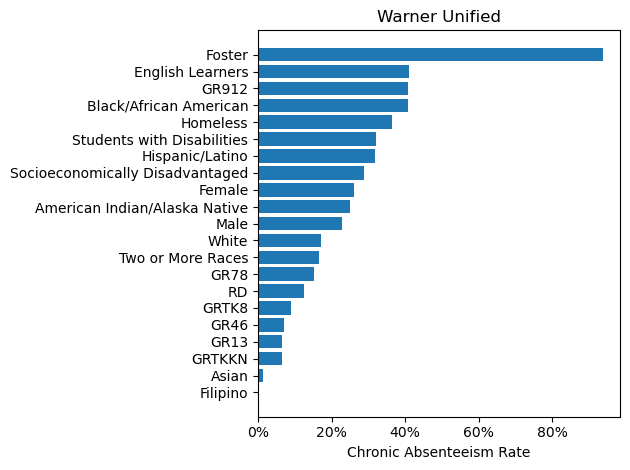

Saved figure: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/subgroup_profile__warner-unified.png


In [15]:
candidates = (
    wide.loc[wide["geo_level"].astype(str).str.lower().eq("district"), "district_name"]
        .dropna().unique()
)
DISTRICT = "Warner Unified"  # or "Burbank Unified School District"
print("District:", DISTRICT)
cat_col = "reporting_category" if "reporting_category" in wide.columns else (
    "subgroup" if "subgroup" in wide.columns else None
)
if cat_col is None:
    raise KeyError("Neither 'reporting_category' nor 'subgroup' is present in your dataframe.")
df = wide.copy()
df = df[
    (df["geo_level"].astype(str).str.lower().eq("district")) &
    (df["district_name"].astype(str).str.strip().eq(DISTRICT))
].copy()

df = df[~df[cat_col].astype(str).str.lower().isin(["all", "all students"])]
df = df.dropna(subset=["chronic_absent_rate"]).sort_values("chronic_absent_rate", ascending=False)

if df.empty:
    print("No subgroups/reporting categories for this district.")
else:
    plt.figure()
    plt.barh(df[cat_col], df["chronic_absent_rate"])
    plt.gca().invert_yaxis()
    plt.xlabel("Chronic Absenteeism Rate")
    plt.title(DISTRICT)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()

ASSETS = Path("/Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets")  # define earlier in the notebook
out_png = ASSETS / f"{cat_col}_profile__{re.sub(r'[^a-z0-9]+','-', DISTRICT.lower()).strip('-')}.png"
plt.savefig(out_png, dpi=150)
plt.show()
print("Saved figure:", out_png.as_posix())

District: San Francisco County Office of Education


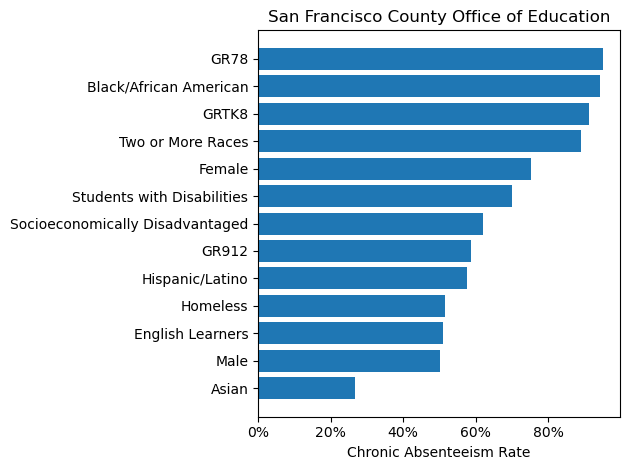

Saved figure: /Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets/subgroup_profile__san-francisco-county-office-of-education.png


In [16]:
candidates = (
    wide.loc[wide["geo_level"].astype(str).str.lower().eq("district"), "district_name"]
        .dropna().unique()
)
DISTRICT = "San Francisco County Office of Education"  # or "Burbank Unified School District"
print("District:", DISTRICT)
cat_col = "reporting_category" if "reporting_category" in wide.columns else (
    "subgroup" if "subgroup" in wide.columns else None
)
if cat_col is None:
    raise KeyError("Neither 'reporting_category' nor 'subgroup' is present in your dataframe.")
df = wide.copy()
df = df[
    (df["geo_level"].astype(str).str.lower().eq("district")) &
    (df["district_name"].astype(str).str.strip().eq(DISTRICT))
].copy()

df = df[~df[cat_col].astype(str).str.lower().isin(["all", "all students"])]
df = df.dropna(subset=["chronic_absent_rate"]).sort_values("chronic_absent_rate", ascending=False)

if df.empty:
    print("No subgroups/reporting categories for this district.")
else:
    plt.figure()
    plt.barh(df[cat_col], df["chronic_absent_rate"])
    plt.gca().invert_yaxis()
    plt.xlabel("Chronic Absenteeism Rate")
    plt.title(DISTRICT)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout()

ASSETS = Path("/Users/ms/Projects/acoe-edu-data-portfolio/projects/01_california-dashboard-replica/assets")  # define earlier in the notebook
out_png = ASSETS / f"{cat_col}_profile__{re.sub(r'[^a-z0-9]+','-', DISTRICT.lower()).strip('-')}.png"
plt.savefig(out_png, dpi=150)
plt.show()
print("Saved figure:", out_png.as_posix())